In [15]:
%reset -f 
from __future__ import absolute_import, print_function
import time
import numpy as np
import pyopencl as cl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy import signal
from matplotlib import rcParams
from scipy import io
import os
from scipy import signal

import locale
os.environ["PYTHONIOENCODING"] = "utf-8"


In [16]:
# Widening the screen
#from IPython.core.display import display, HTML
from IPython.display import display, HTML  
display(HTML("<style>.container { width:90% !important; }</style>"))

rcParams['figure.dpi'] = 100
rcParams['font.size'] = 16
rcParams['font.family'] = 'StixGeneral'
rcParams["mathtext.fontset"] = 'stix'
rcParams['animation.embed_limit'] = 2**128
plt.rc('font', size=16)          # controls default text sizes
plt.rc('axes', titlesize=16)     # fontsize of the axes title
plt.rc('axes', labelsize=16)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=16)   # fontsize of the figure title


## Model description

equations:

$\displaystyle \frac{\partial u}{\partial t}=  -k_d u +  f(u,v)\cdot v -\rho g(u,v) \cdot u +D_u \Delta u$

$\displaystyle \frac{\partial v}{\partial t}=+k_d u- f(u,v)\cdot v -\rho g(u,v) \cdot u +D_v \Delta v $

u: DNA-bound proteins concentration

v: free protein concentration

$\rho$: DNA length or stability of DNA-bound protein


$Du<<Dv$

Here,we take $\displaystyle f(u,v)= k_1 u +\frac{\tilde{b}}{k_3}=k_1u+b$ , $\displaystyle g(u,v)=\frac{ k_2  \cdot \beta}{k_2+u+v}$

## Parameters in the model


In [17]:
kd=0.36 # Dissociation rate constant
k3=6.7 # intensity conversion factor
k1=1.35 #recruitment rate coefficient
tildeb=60 #self-triggering rate
b=tildeb/k3
rho=4.0 #5.0 # stability: default set as estimated half-saturation concentration of DNA
k2=2.0 # half-saturation constant : threshold concentration
beta=17.8*1.1 # maximal reduction of intensity per hour (estimated)
Du=0.17*0.05 # diffusion for DNA-bound protein
Dv=0.17 # diffusion for free protein
cv=0.016*6.7 #constant speed up calculation

In [18]:
length    = 512    # 2.5 Length of the physical landscape
n         = 512# Size of the 2D grid
#n         =256
#n=128
endtime   = 1000#60*24.0*3    # end time
#endtime=1e5
dT        = 0.001 #0.01       # 0.02     #calculate time step
nplot     = 100
nsteps    = np.ceil(endtime/nplot/dT).astype(int)    # number of time steps

## simulation settings

In [19]:
dX =0.2#length/n      # Spatial step size
dY = 0.2#length/n      # Spatial step size
Grid_Width  = n
Grid_Height = n
# %% Reporting in the simulation on the console
print(" Current grid dimensions: %d x %d cells\n" % (Grid_Width, Grid_Height));

 Current grid dimensions: 512 x 512 cells



In [20]:
platforms = cl.get_platforms()
Devices = platforms[0].get_devices()
print(len(Devices))
# Setting up the OpenCL context
#DeviceNr = 2   # 0 = GTX 960M
DeviceNr = 0   # 0= Quadro K5200
platform = cl.get_platforms()
Devices  = platform[0].get_devices()  # 0 = GPU
context  = cl.Context([Devices[DeviceNr]])
queue    = cl.CommandQueue(context)
mf       = cl.mem_flags # Memory flags are set
print(" Compute Device: %s\n" % Devices[DeviceNr].name)

1
 Compute Device: Apple M2 Ultra



## simulation allocated on the GPU


In [21]:
u0= 0.5 # initial DNA-bound protein concentration
u= u0+  (np.random.rand(n*n)-0.5)*0.2   # u ~(0,0.5)
v0=20.0 # initial free-protein concentration
v=v0+ (np.random.rand(n*n)-0.5)*0.5 # v~(27.5,28.5)

## record initial data
u_origin=u
v_origin=v

## preparation for opencl operations
u_host   = u.astype(np.float32)
u_g      = cl.Buffer(context, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=u_host)
v_host   = v.astype(np.float32)
v_g      = cl.Buffer(context, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=v_host)


In [22]:
with open('SpatialFunctions_iPy.cl', 'r',encoding='utf-8') as myfile:
   SpatialFunctions = myfile.read()

In [23]:
# List of parameters for the OpenCL kernel. Seperate with comma without spaces
# Setting up the parameters for the Kernel
PassVars="kd,k3,k1,b,k2,rho,cv,beta,Du,Dv,dX,dY,dT,Grid_Width,Grid_Height"
PassVals=eval(PassVars)
PassVars=PassVars.split(',')
Params=""

for ii in range(len(PassVals)):
    Params = Params+"#define " + PassVars[ii] + " " + str(PassVals[ii]) + " \n"

In [24]:
ComputeCode = """

///////////////////////////////////////////////////////////////////////////////
// Simulation kernel
///////////////////////////////////////////////////////////////////////////////   

__kernel void SimulationKernel (__global float* u, __global float* v)
{
    size_t current  = get_global_id(0);
    size_t row      = floor((float)current/(float)Grid_Width);
    size_t column   = current%Grid_Width;

        if (row > 0 && row < Grid_Width-1 && column > 0 && column < Grid_Height-1)
            {
              
                float dudt =  cv*(-kd*u[current] + (k1*u[current]+b)*v[current] - rho*k2*beta*u[current]/(k2+u[current]+v[current])) + Du*d2_dxy2(u); 
                float dvdt =  -cv*(-kd*u[current] + (k1*u[current]+b)*v[current] - rho*k2*beta*u[current]/(k2+u[current]+v[current])) + Dv*d2_dxy2(v); 
              
             u[current] = u[current]+dudt*dT;
             v[current] = v[current] +dvdt*dT; 
            } 
        // HANDLE Boundaries
        else 
            {
              PeriodicBoundaries(u);
              PeriodicBoundaries(v);
             //NeumannBoundaries(u);
             //NeumannBoundaries(v);
             
            }
} // End SimulationKernel
"""

In [25]:
program = cl.Program(context, Params + SpatialFunctions + ComputeCode).build()

from ipywidgets import FloatProgress
from IPython.display import display

# Setting up a progress bar for the simulation
print("Progress :");
PB = FloatProgress(min=0, max=nplot); display(PB) 
Us=np.zeros((Grid_Width, Grid_Height, nplot))
Vs=np.zeros((Grid_Width, Grid_Height, nplot))

# Set up simulation parameters
global_size = u_host.shape

# Start the timer:
start_time = time.time()

# Starting the loop
for ii in range(1,nplot):
    # The simulation
    for jj in range(1,nsteps):            
#         cl.enqueue_copy(queue, A_host, A_g)
#         phic = signal.convolve2d(A_host.reshape(n,n), C, mode='same', boundary='wrap')                     
#         phic_host = phic.reshape(n*n,order='C').astype(np.float32)
#         phic_g    = cl.Buffer(context, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=phic_host)
#         program.SimulationKernel(queue, global_size, None, A_g, B_g, phic_g)
        program.SimulationKernel(queue, global_size, None, u_g, v_g)

    # Get the data from the GPU
    cl.enqueue_copy(queue, u_host, u_g)
    cl.enqueue_copy(queue, v_host, v_g)
    
    # We store the state of the system for <NumPlot> different times.
    Us[:,:,ii] = u_host.reshape(Grid_Width, Grid_Height)
    Vs[:,:,ii] = v_host.reshape(Grid_Width, Grid_Height)
    
    PB.value += 1 # signal to increment the progress bar

# Determining the time that we used for the simulation
elapsed_time = time.time() - start_time    
print(" Simulation took      : %1.1f (s)" % (elapsed_time))

Progress :


FloatProgress(value=0.0)

 Simulation took      : 130.3 (s)


In [26]:
from scipy import io
import os
if not os.path.exists("Data"):
    os.makedirs("Data")
io.savemat('Data/bound_pro_'+str(v0)+'.mat', {'u': Us})
io.savemat('Data/free_pro_'+str(v0)+'.mat', {'v': Vs})
# load data: mathfn.mat from Matlab
# data = io.loadmat(matfn) 

In [ ]:
### The Simulation loop
from matplotlib import ticker
# plot_color_gradients('Sequential',
#                      ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
#                       'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
#                       'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn'])
# plot_color_gradients('Sequential (2)',
#                      ['binary', 'gist_yarg', 'gist_gray', 'gray', 'bone',
#                       'pink', 'spring', 'summer', 'autumn', 'winter', 'cool',
#                       'Wistia', 'hot', 'afmhot', 'gist_heat', 'copper'])
nbin=4
# viridis, Reds, Greens, YlGn
#orig_map=plt.cm.get_cmap('copper') # viridis  YlGn, summer
orig_map=plt.colormaps.get_cmap('GnBu')
reversed_map = orig_map.reversed()

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
im0 = ax[0].imshow((u_host-0.0).reshape(n,n),cmap=reversed_map,extent=[0,length,0,length], clim=(0,20));#, clim=(0,0.1));
ax[0].set_title('concentration of $u$ (DNA-bound protein)');

cbar=plt.colorbar(im0, ax=ax[0],fraction=0.046,pad=0.04);
# ax[0].set_yticks(np.linspace(0,length,5))
tick_locator = ticker.MaxNLocator(nbins=4)
cbar.locator = tick_locator
cbar.update_ticks()
im1 = ax[1].imshow(v_host.reshape(n,n),cmap=reversed_map,extent=[0,length,0,length],clim=(0,20));#, clim=(0,0.5));
ax[1].set_title('concentration of $v$ (free protein)');
cbar=plt.colorbar(im1, ax=ax[1],fraction=0.046,pad=0.04);
tick_locator = ticker.MaxNLocator(nbins=4)
cbar.locator = tick_locator
cbar.update_ticks()
# fig.tight_layout()

text=fig.suptitle("Time: %1.0f of %1.0f" % (endtime, endtime), x=0.5, y=0.1, fontsize=16);

([], [])

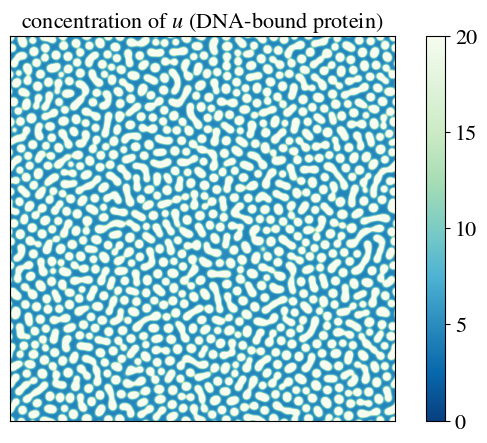

In [28]:
nbin=4
# viridis, Reds, Greens, YlGn
# plot_color_gradients('Sequential',
#                      ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
#                       'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
#                       'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn'])
# plot_color_gradients('Sequential (2)',
#                      ['binary', 'gist_yarg', 'gist_gray', 'gray', 'bone',
#                       'pink', 'spring', 'summer', 'autumn', 'winter', 'cool',
#                       'Wistia', 'hot', 'afmhot', 'gist_heat', 'copper'])

#orig_map=plt.cm.get_cmap('viridis') # viridis  YlGn, summer
orig_map=plt.colormaps['GnBu']
reversed_map = orig_map.reversed()

from matplotlib import ticker
fig, ax2 = plt.subplots(1, 1, figsize=(10, 5))
im0 = ax2.imshow((u_host).reshape(n,n),cmap=reversed_map,extent=[0,length,0,length],clim=(0,20));#, clim=(0,0.5));
#im1 = ax[1].imshow(B_host.reshape(n,n),cmap=reversed_map,extent=[0,length,0,length],clim=(0,30));#, clim=(0,0.5));
ax2.set_title('concentration of $u$ (DNA-bound protein)');
cbar=plt.colorbar(im0, ax=ax2,fraction=0.046,pad=0.04);
# ax[1].set_yticks(np.linspace(0,length,5))
tick_locator = ticker.MaxNLocator(nbins=4)
cbar.locator = tick_locator
cbar.update_ticks()
# fig.tight_layout()
plt.xticks([])
plt.yticks([])
#text=fig.suptitle("Time: %1.0f of %1.0f" % (endtime, endtime), x=0.5, y=0.1, fontsize=16);